In [1]:
# Set up the default parameters
# 1. The code block will be shown in the document
# 2. set up figure display size
# 3. turn off all the warnings and messages

knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.width = 8, fig.height = 4)
knitr::opts_chunk$set(warning = FALSE, message = FALSE)


## Background

Individuals stock prices tend to exhibit high amounts of non-constant variance, and thus ARIMA models build upon that data would likely exhibit non-constant variance in residuals. In this problem we are going to analyze the Intel stock price data from 2012 through end of 2021. We will use the ARIMA-GARCH to model daily and weekly stock price (adjusted close price at the end of a day for daily data or at the end of the week for weekly data), with a focus on the behavior of its volatility as well as forecasting both the price and the volatility.

##Data import and cleaning


In [10]:
## Libraries used within this homework are uploaded here
library(zoo,warn.conflicts=FALSE)
library(lubridate,warn.conflicts=FALSE)
library(mgcv,warn.conflicts=FALSE)
library(rugarch,warn.conflicts=FALSE)
library(ggplot2)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar



In [12]:
#importing the data
dailydata <- read.csv("INTCDaily.csv", head = TRUE)
weeklydata <- read.csv("INTCWeekly.csv", head = TRUE)
#cleaning the data
#dates to date format
weeklydata$Date<-as.Date(weeklydata$Date,format='%m/%d/%y')
dailydata$Date<-as.Date(dailydata$Date,format='%m/%d/%y')

#prices to timeseries format
INTWeekly <- ts(weeklydata$Adj.Close,start=c(2012,1,1),freq=52)
INTDaily <- ts(dailydata$Adj.Close,start=c(2012,1,1),freq=252)
 

[1] 18.34137 18.26147 19.16220 19.41643 19.42369 19.54962

# Question 1: Exploratory Data Analysis (20 points)

**1a.** Based on your intuition, when would you use daily vs weekly stock price data?

*Response: Question 1a*

Daily stock price data is expected to experience more changes and be more chaotic than the weekly data. I would use the daily data if the goal was to predict future trends on a daily basis. Likewise, I would use weekly data if the expectations were for predictions to be at the weekly granularity. 

**1b.** Plot the time series plots  comparing daily vs weekly data. How do the daily vs weekly time series data compare?

Warning message:
“Removed 2265 row(s) containing missing values (geom_path).”
Warning message:
“Removed 470 row(s) containing missing values (geom_path).”


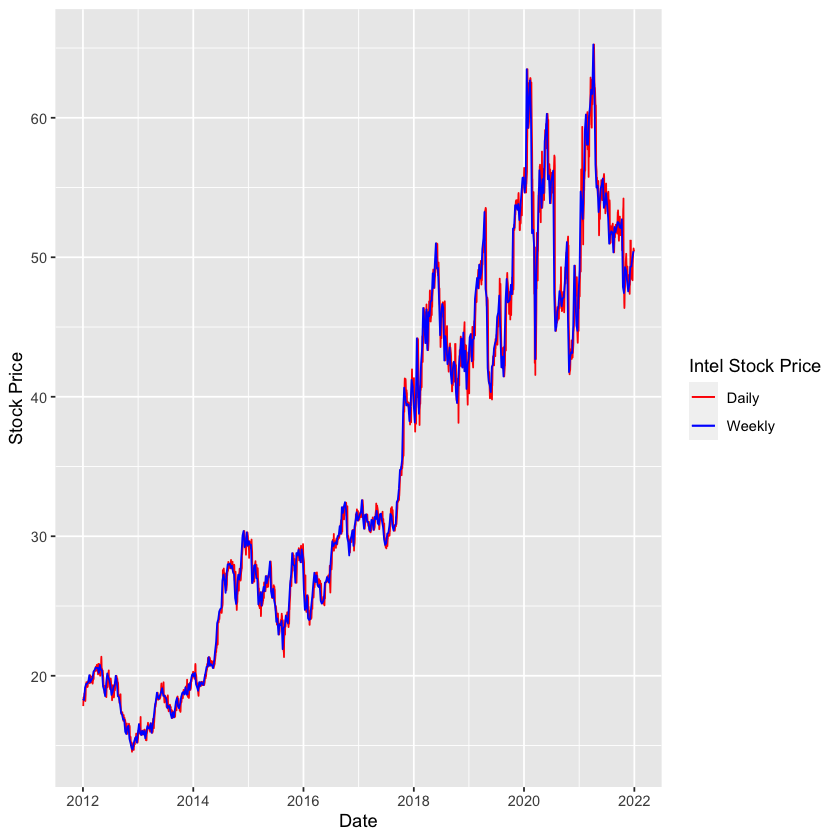

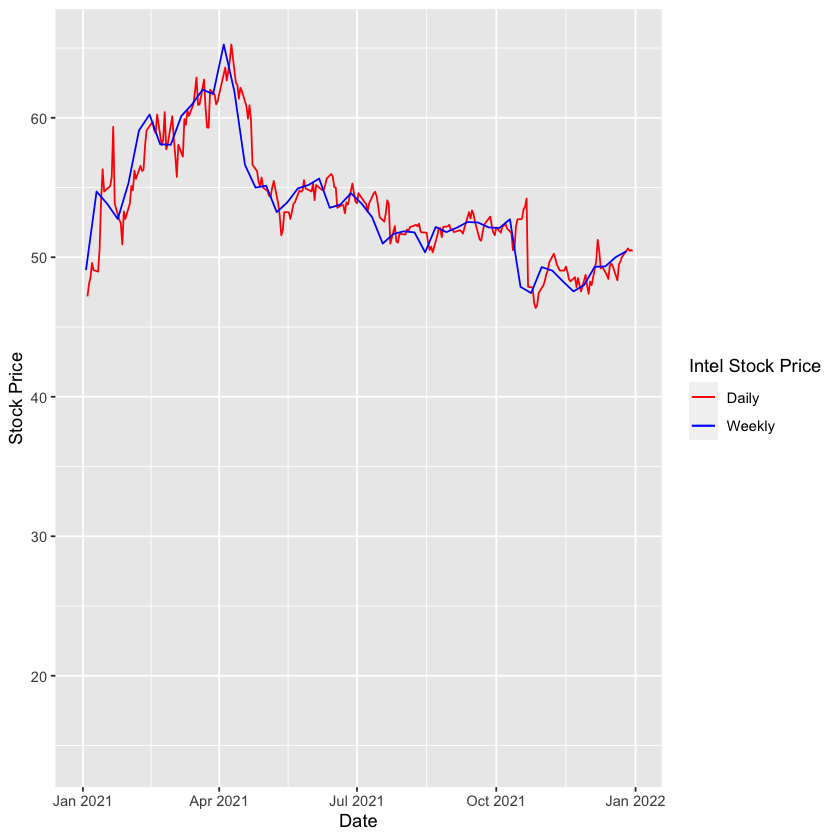

In [23]:
ggplot() + 
  geom_line(data = dailydata, aes(x = Date, y = Adj.Close, color="Daily")) +
  geom_line(data = weeklydata, aes(x = Date, y = Adj.Close, color = "Weekly")) +
  xlab('Date') +
  ylab('Stock Price') + scale_color_manual(name='Intel Stock Price',
                     breaks=c('Daily', 'Weekly'),
                     values=c('Daily'='red', 'Weekly'='blue'))

ggplot() + 
  geom_line(data = dailydata, aes(x = Date, y = Adj.Close, color="Daily")) +
  geom_line(data = weeklydata, aes(x = Date, y = Adj.Close, color = "Weekly")) +
  xlab('Date') + xlim(as.Date(c('2021-01-01','2021-12-31'))) +
  ylab('Stock Price') + scale_color_manual(name='Intel Stock Price',
                     breaks=c('Daily', 'Weekly'),
                     values=c('Daily'='red', 'Weekly'='blue'))

*Response: Question 1b*

As expected the weekly data is a smoothed version of the daily data. The weekly data doesn't expereience the peaks and valleys experienced by the daily data but does follow the same trend. To show this phenomena clearly I plotted the data just for calendar year 2021.

**1c.** Fit a non-parametric trend using splines regression to both the daily and weekly time-series data. Overlay the fitted trends. How do the trends compare?

*Response: Question 1c*

**1d.** Consider the return stock price computed as provided in the canvas homework assignment. 
Apply this formula to compute the return price based on the daily and weekly time series data. Plot the return time series and their corresponding ACF plots. How do the return time series compare in terms of stationarity and serial dependence?

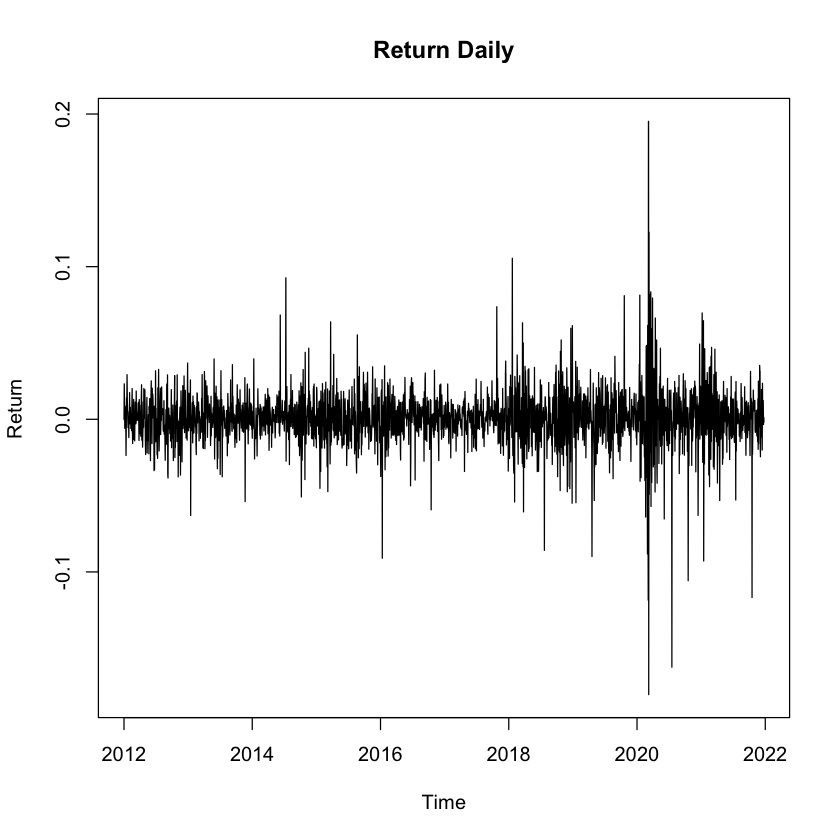

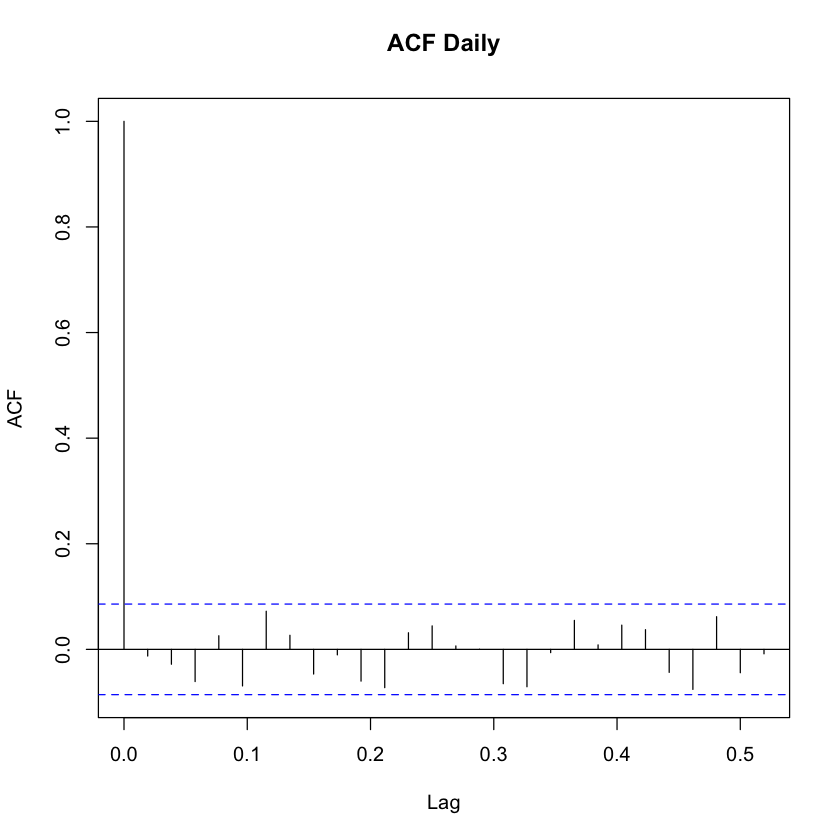

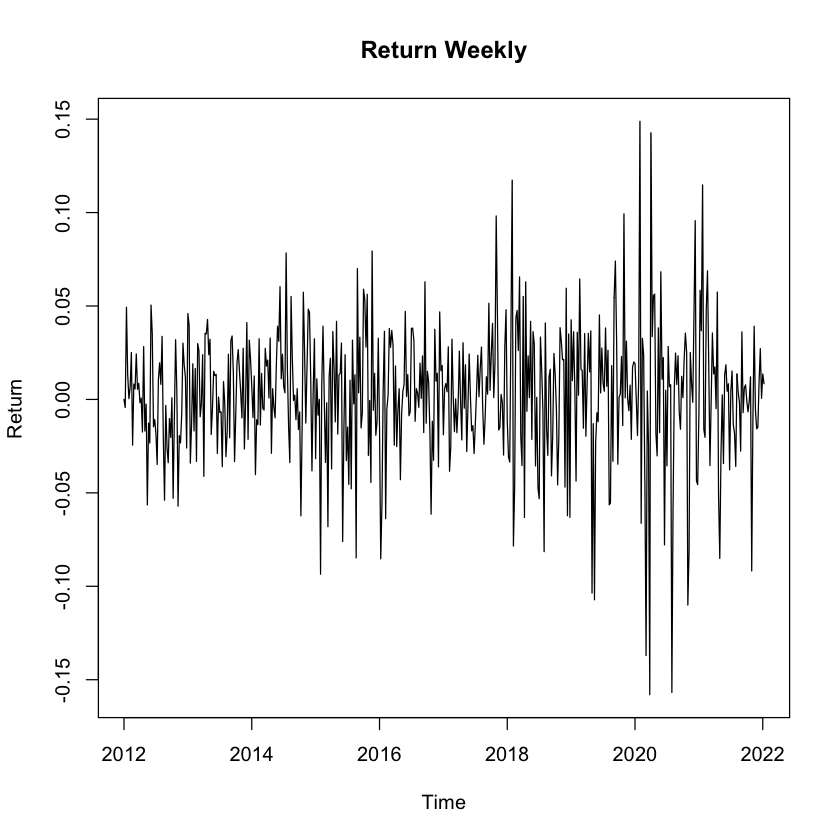

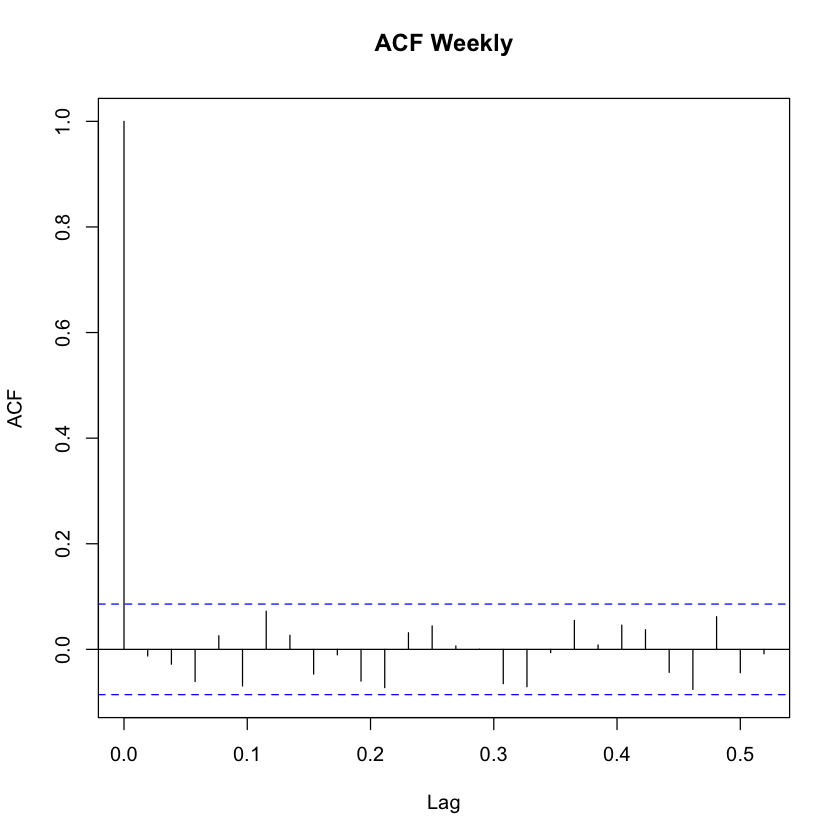

In [33]:
# Calculate return of daily
returnDaily <- diff(INTDaily) / INTDaily[- length(INTDaily)]
returnDaily <- c(0,returnDaily)
returnDaily.ts <- ts(returnDaily, start = c(2012, 1, 1), frequency = 252)

plot.ts(returnDaily.ts, main="Return Daily", ylab="Return")
acf(returnWeekly.ts, main="ACF Daily")

#Calculate return of weekly
returnWeekly <- diff(INTWeekly) / INTWeekly[- length(INTWeekly)]
returnWeekly <- c(0,returnWeekly)
returnWeekly.ts <- ts(returnWeekly, start = c(2012, 1, 1), frequency = 52)

plot.ts(returnWeekly.ts, main="Return Weekly", ylab="Return")
acf(returnWeekly.ts, main="ACF Weekly")

*Response: Question 1d*

# Question 2: ARIMA(p,d,q) for Stock Price (20 Points)

**2a.** Divide the data into training and testing data set, where the training data exclude the last week of data (December 27th - December 30th) with the testing data including the last week of data. Apply the iterative model to fit an ARIMA(p,d,q) model with max AR and MA orders of 8 and difference orders 1 and 2 separately to the training datasets of the daily and weekly data. Display the summary of the final model fit.

**2b.** Evaluate the model residuals and squared residuals using the ACF and PACF plots as well as hypothesis testing for serial correlation. What would you conclude based on this analysis?

*Response: Question 2b*

**2c.** Apply the model identified in (2a) and forecast the last week of data. Plot the predicted data to compare the predicted values to the actual observed ones. Include 95% confidence intervals for the forecasts in the corresponding plots.

**2d.** Calculate Mean Absolute Percentage Error (MAPE) and Precision Measure (PM) (PM only for daily data). How many observations are within the prediction bands?  Compare the accuracy of the predictions for the daily and weekly time series using these two measures.  

*Response: Question 2d*

# Question 3: ARMA(p,q)-GARCH(m,n) for Return Stock Price (20 Points)

**3a.** Divide the data into training and testing data set, where the training data exclude the last week of data (December 27th - December 30th) with the testing data including the last week of data. Apply the iterative model to fit an ARMA(p,q)-GARCH(m,n) model by selecting the orders for p & q up to 5 and orders for m & n up to 2. Display the summary of the final model fit. Write up the equation of the estimated model.

*Response: Question 3a*

**3b.** Evaluate the model residuals and squared residuals using the ACF and PACF plots as well as hypothesis testing for serial correlation. What would you conclude based on this analysis?

*Response: Question 3b*

**3c.** Apply the model identified in (3a) and forecast the mean and the variance of the last week of data. Plot the predicted data to compare the predicted values to the actual observed ones. Interpret the results, particularly comparing forecast using daily versus weekly data.

*Response: Question 3c*

**3d.** Calculate Mean Absolute Percentage Error (MAPE) and Precision Measure (PM) for the mean forecasts (PM should net be calculated for weekly data).  Compare the accuracy of the predictions for the daily and weekly time series using these two measures.

*Response: Question 3d*

# Question 4: Reflection on the Modeling and Forecasting (10 points) 

Based on the analysis above, discuss the application of ARIMA on the stock price versus the application of ARMA-GARCH on the stock return. How do the models fit the data? How well do the models predict?  How do the models perform when using daily versus weekly data? Would you use one approach over another for different settings? What are some specific points of caution one would need to consider when applying those models?

*Response: Question 4*